In [25]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sparse



In [26]:

from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier


In [27]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import recall_score

In [28]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import train_test_split

C:\Users\siska hutagaol\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [29]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from nltk.corpus import stopwords
from sklearn.cross_validation import StratifiedKFold
from sklearn.naive_bayes import BernoulliNB


## 1. Reading the data from the Sqlite file

In [6]:
## download dataset from this location : https://www.kaggle.com/snap/amazon-fine-food-reviews.

In [30]:
sqlobject = sqlite3.connect('./database.sqlite')

reviews = pd.read_sql_query("""SELECT Score, Summary FROM Reviews""", sqlobject)


In [31]:
original = reviews.copy()

In [32]:
reviews = original.copy()

In [33]:
print(reviews.shape)

(568454, 2)


In [34]:
reviews = reviews.dropna()

In [35]:
print (reviews.shape)

(568454, 2)


In [6]:
## this is how loaded data looks like

In [36]:
print (reviews.head(50))

    Score                                            Summary
0       5                              Good Quality Dog Food
1       1                                  Not as Advertised
2       4                              "Delight" says it all
3       2                                     Cough Medicine
4       5                                        Great taffy
5       4                                         Nice Taffy
6       5      Great!  Just as good as the expensive brands!
7       5                             Wonderful, tasty taffy
8       5                                         Yay Barley
9       5                                   Healthy Dog Food
10      5                    The Best Hot Sauce in the World
11      5  My cats LOVE this "diet" food better than thei...
12      1               My Cats Are Not Fans of the New Food
13      4                                  fresh and greasy!
14      5                       Strawberry Twizzlers - Yummy
15      5           Lots

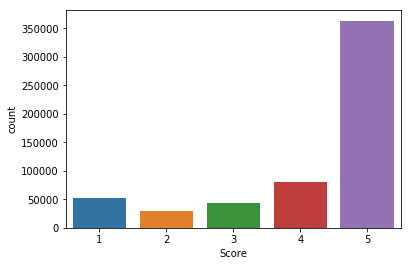

In [37]:
import seaborn as sbn
sbn.countplot(reviews['Score'])

### We can see above that there are no missing values

## 2. Encoding score to Positive or negative based on value of each sample

In [38]:
scores = reviews['Score']

reviews['Score'] = reviews['Score'].apply(lambda x : 'pos' if x > 3 else 'neg')
# reviews['Score'] = reviews['Score'].apply(lambda x : 'pos' if x > 3 else 'neg')

In [39]:
scores.mean()

4.183198640523243

## 3. Distribution of labels in the dataset

In [40]:
reviews.groupby('Score')['Summary'].count()

Score
neg    124677
pos    443777
Name: Summary, dtype: int64

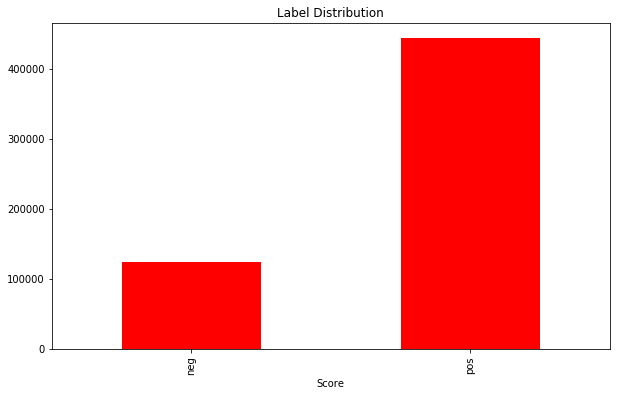

In [41]:
reviews.groupby('Score')['Summary'].count().plot(kind='bar',color=['r','g'],title='Label Distribution',figsize=(10,6))

In [42]:
print ('Percentage of negative reviews %.2f %%' % ((reviews.groupby('Score')['Summary'].count()['neg'])*100.0/len(reviews)))
print ('Percentage of positive reviews %.2f %%' % ((reviews.groupby('Score')['Summary'].count()['pos'])*100.0/len(reviews)))

Percentage of negative reviews 21.93 %
Percentage of positive reviews 78.07 %


### As we can see the data is pretty skewed. We are able to already decide that we must use Stratified Split for evaluation

## 4. Splitting the dataset based on labels

In [43]:
def splitPosNeg(Summaries):
    neg = reviews.loc[Summaries['Score']=='neg']
    pos = reviews.loc[Summaries['Score']=='pos']
    return [pos,neg]

In [44]:
[pos,neg] = splitPosNeg(reviews)

## 5. Preprocessing

### Using lemmatization as it was giving better results than stemming. Other steps include removing punctuation amd upper case to lower case conversion.

In [35]:
# nltk.download()

In [45]:
#preprocessing steps

#stemmer = PorterStemmer()
lemmatizer = nltk.WordNetLemmatizer()
stop = stopwords.words('english')
translation = str.maketrans(string.punctuation,' '*len(string.punctuation))

def preprocessing(line):
    tokens=[]
    line = line.translate(translation)
    line = nltk.word_tokenize(line.lower())
    for t in line:
#         if(t not in stop):
#             stemmed = stemmer.stem(t)
        stemmed = lemmatizer.lemmatize(t)
        tokens.append(stemmed)
    return ' '.join(tokens)

In [46]:
pos_data = []
neg_data = []
for p in pos['Summary']:
    pos_data.append(preprocessing(p))

for n in neg['Summary']:
    neg_data.append(preprocessing(n))    
    
    

In [47]:
data = pos_data + neg_data
labels = np.concatenate((pos['Score'].values,neg['Score'].values))

## 6. Splitting the data into train and test using a stratified strategy

In [48]:
[Data_train,Data_test,Train_labels,Test_labels] = train_test_split(data,labels , test_size=0.25, random_state=20160121,stratify=labels)

In [224]:
## tokenizing the training data to find frequency of words

In [49]:
t = []
for line in Data_train:
    l = nltk.word_tokenize(line)
    for w in l:
        t.append(w)

In [50]:
word_features = nltk.FreqDist(t)
print (len(word_features))

27048


### We can see that the number of unique words in the dataset is pretty huge. When doing text classification the vocabulary of the data set becomes the featureset.
### We would want to reduce the size of this feature set. This can be done in severals ways.
### One of them is feature reduction using PCA.

## 7. Feature Reduction

### a. Using PCA

In [51]:
vec_all = CountVectorizer()
ctr_features_all = vec_all.fit_transform(Data_train)

In [52]:
tf_vec_all = TfidfTransformer()
tr_features_all = tf_vec_all.fit_transform(ctr_features_all)

In [53]:
cte_features_all = vec_all.transform(Data_test)
te_features_all = tf_vec_all.transform(cte_features_all)

#### Pca doesn't apply to sparse matrices so we use a different version of PCA called Truncated SVD

In [54]:
svd = TruncatedSVD(n_components=200)
tr_features_truncated = svd.fit_transform(tr_features_all)

In [ ]:
te_features_truncated = svd.transform(te_features_all)

In [ ]:
svd = TruncatedSVD(n_components=200)
ctr_features_truncated = svd.fit_transform(ctr_features_all)
cte_features_truncated = svd.transform(cte_features_all)

### Running 4 classification algorithms : Naive Bayes, Logistic Regression, Decision Trees and Perceptron

In [ ]:
models = {'BernoulliNB':BernoulliNB(binarize=0.5)
          ,'Logistic' : linear_model.LogisticRegression(C=1e5),'Decision Tree' : DecisionTreeClassifier(random_state=20160121, criterion='entropy'),
                                                                                                        'Perceptron': linear_model.Perceptron(n_iter=1000)}

In [ ]:
results_svd = pd.DataFrame()

foldnum = 0
tfprediction = {}
cprediction = {}
for name,model in models.items():
        model.fit(tr_features_truncated, Train_labels)
        tfprediction[name] = model.predict(te_features_truncated)
        tfaccuracy = metrics.accuracy_score(tfprediction[name],Test_labels)
        
        #model.fit(ctr_features_truncated,Train_labels)
        #cprediction[name] = model.predict(cte_features_truncated)
        #caccuracy = metrics.accuracy_score(cprediction[name],Test_labels)

        results_svd.loc[foldnum,'Model']=name
        results_svd.loc[foldnum,'TF-IDF Accuracy']=tfaccuracy
        #results_svd.loc[foldnum,'Count Accuracy']=caccuracy
        foldnum = foldnum+1
print (results_svd)


In [ ]:
for name,model in models.items():
    print ("Classification report for ",name)
    print(metrics.classification_report(Test_labels, tfprediction[name]))
    print("\n")

In [ ]:
results_svd.plot(kind='bar',color=['r','g','b','y'],title='Model Performance',figsize=(10,6),x='Model',legend=False)

In [ ]:
## comparing negative samples accuracies
negcom = pd.DataFrame()
for name,model in models.items():
    p= recall_score(Test_labels,tfprediction[name],pos_label='neg')
    negcom.loc[name,'recall'] = p

In [ ]:
pl = negcom.plot(kind='bar',color=['r','g','b','y'],title='Using PCA',figsize=(10,6),legend=False)
pl.set(xlabel='Models',ylabel='Recall for negative samples')
lim = plt.ylim([0,1])

#### The performance seems to be okay but we can try improving it further

### Another way to reduce feature set is to have better feature selection. We can use the most frequent 5000 features as the featureset

## 8. Feature Selection

In [ ]:
topwords = [fpair[0] for fpair in list(word_features.most_common(5000))]

In [ ]:
print (word_features.most_common(25))

In [ ]:
word_his = pd.DataFrame(word_features.most_common(25),columns=['words','count'])

In [ ]:
print (word_his)

In [ ]:
word_his.plot(kind='bar',x=word_his['words'],legend=False,title='Top 20 most freq words',figsize=(10,6))

In [ ]:
vec = CountVectorizer()
c_fit = vec.fit_transform([' '.join(topwords)])

In [ ]:
tf_vec = TfidfTransformer()
tf_fit = tf_vec.fit_transform(c_fit)

In [ ]:
ctr_features = vec.transform(Data_train)
tr_features = tf_vec.transform(ctr_features)

In [ ]:
cte_features = vec.transform(Data_test)
te_features = tf_vec.transform(cte_features)

In [ ]:
models = {'BernoulliNB':BernoulliNB()
          ,'Logistic' : linear_model.LogisticRegression(C=1e5),'Decision Tree' : DecisionTreeClassifier(random_state=20160121, criterion='entropy'),
          'Perceptron': linear_model.Perceptron(n_iter=1000)}

In [ ]:
results = pd.DataFrame()

foldnum = 0
tfprediction = {}
cprediction = {}
for name,model in models.items():
        
        model.fit(tr_features, Train_labels)
        tfprediction[name] = model.predict(te_features)
        tfaccuracy = metrics.accuracy_score(tfprediction[name],Test_labels)
        
        #model.fit(ctr_features,Train_labels)
        #cprediction[name] = model.predict(cte_features)
        #caccuracy = metrics.accuracy_score(cprediction[name],Test_labels)
        
        results.loc[foldnum,'TF-IDF Accuracy']=tfaccuracy
        #results.loc[foldnum,'Count Accuracy']=caccuracy
        results.loc[foldnum,'Model']=name
        foldnum = foldnum+1
print (results)


In [ ]:
for name,model in models.items():
    print ("Classification report for ",name)
    print(metrics.classification_report(Test_labels, tfprediction[name]))
    print("\n")

In [ ]:
results.plot(kind='bar',color=['r','g','b','y'],title='Model Performance',figsize=(10,6),x='Model',legend=False)

In [ ]:
## comparing negative samples accuracies
negcom = pd.DataFrame()
for name,model in models.items():
    p= recall_score(Test_labels,tfprediction[name],pos_label='neg')
    negcom.loc[name,'recall'] = p


In [ ]:
pl = negcom.plot(kind='bar',color=['r','g','b','y'],title='Most Freq Features',figsize=(10,6),legend=False)
pl.set(xlabel='Models',ylabel='Recall')
lim = plt.ylim([0,1])

## 9. Finally we can try by running it on our entire featureset. One can guess it will take a lot of time with Decision Tree Classifier.

### We can make use of group of words to get better results. Sometimes sequence of words might have different effect on the prediction. Sequences like "not good" or "not bad" affect the prediction in way different than when used individually.

### a. Unigram

In [ ]:
### using countvectorizer to generate count vectors for the training data.
vec_all = CountVectorizer()
ctr_features_all = vec_all.fit_transform(Data_train)

In [ ]:
tf_vec_all = TfidfTransformer()
tr_features_all = tf_vec_all.fit_transform(ctr_features_all)

In [ ]:
cte_features_all = vec_all.transform(Data_test)
te_features_all = tf_vec_all.transform(cte_features_all)

In [ ]:
models = {'BernoulliNB':BernoulliNB()
          ,'Logistic' : linear_model.LogisticRegression(C=1e5),'Perceptron': linear_model.Perceptron(n_iter=1000)}

In [ ]:
results_all_uni = pd.DataFrame()

#stratified = StratifiedKFold(labels, n_folds=5,random_state=20160121, shuffle=True)

foldnum = 0
tfprediction = {}
cprediction = {}
for name,model in models.items():
        
        model.fit(tr_features_all, Train_labels)
        tfprediction[name] = model.predict(te_features_all)
        tfaccuracy = metrics.accuracy_score(tfprediction[name],Test_labels)
        
        #model.fit(ctr_features_all,Train_labels)
        #cprediction[name] = model.predict(cte_features_all)
        #caccuracy = metrics.accuracy_score(cprediction[name],Test_labels)
        
        results_all_uni.loc[foldnum,'TF-IDF Accuracy']=tfaccuracy
        #results_all_uni.loc[foldnum,'Count Accuracy']=caccuracy
        results_all_uni.loc[foldnum,'Model']=name
        foldnum = foldnum+1
print (results_all_uni)


In [ ]:
for name,model in models.items():
    print ("Classification report for ",name)
    print(metrics.classification_report(Test_labels, tfprediction[name]))

In [ ]:
results_all_uni.plot(kind='bar',color=['r','g','b'],title='Model Performance',figsize=(10,6),x='Model',legend=False)

In [ ]:
## comparing negative samples accuracies
negcom = pd.DataFrame()
for name,model in models.items():
    p= recall_score(Test_labels,tfprediction[name],pos_label='neg')
    negcom.loc[name,'recall'] = p

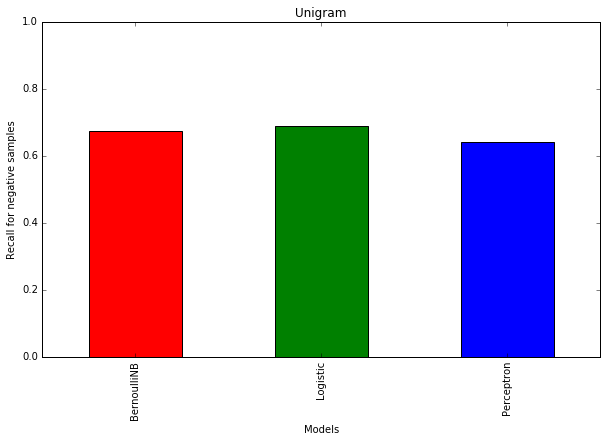

In [203]:
pl = negcom.plot(kind='bar',color=['r','g','b','y'],title='Unigram',figsize=(10,6),legend=False)
pl.set(xlabel='Models',ylabel='Recall for negative samples')
lim = plt.ylim([0,1])

### b. Using Bigrams

In [204]:
## using countvectorizer to generate count vectors for the training data.
vec_all = CountVectorizer(ngram_range=(1,2))
ctr_features_all = vec_all.fit_transform(Data_train)

In [205]:
tf_vec_all = TfidfTransformer()
tr_features_all = tf_vec_all.fit_transform(ctr_features_all)

In [206]:
cte_features_all = vec_all.transform(Data_test)
te_features_all = tf_vec_all.transform(cte_features_all)

In [207]:
print ((ctr_features_all.shape))

(426340, 263567)


In [208]:
results_all_bi = pd.DataFrame()

#stratified = StratifiedKFold(labels, n_folds=5,random_state=20160121, shuffle=True)
tfprediction = {}
cprediction = {}
foldnum = 0
for name,model in models.items():
        
        model.fit(tr_features_all, Train_labels)
        tfprediction[name] = model.predict(te_features_all)
        tfaccuracy = metrics.accuracy_score(tfprediction[name],Test_labels)
        
        #model.fit(ctr_features_all,Train_labels)
        #cprediction[name] = model.predict(cte_features_all)
        #caccuracy = metrics.accuracy_score(cprediction[name],Test_labels)
        
        results_all_bi.loc[foldnum,'TF-IDF Accuracy']=tfaccuracy
        #results_all_bi.loc[foldnum,'Count Accuracy']=caccuracy
        results_all_bi.loc[foldnum,'Model']=name
        foldnum = foldnum+1
print (results_all_bi)


   TF-IDF Accuracy        Model
0         0.887231  BernoulliNB
1         0.928550     Logistic
2         0.903760   Perceptron


In [209]:
for name,model in models.items():
    print ("Classification report for ",name)
    print(metrics.classification_report(Test_labels, tfprediction[name]))
    print("\n")

Classification report for  BernoulliNB
             precision    recall  f1-score   support

        neg       0.79      0.67      0.72     31169
        pos       0.91      0.95      0.93    110945

avg / total       0.88      0.89      0.88    142114



Classification report for  Logistic
             precision    recall  f1-score   support

        neg       0.86      0.80      0.83     31169
        pos       0.95      0.96      0.95    110945

avg / total       0.93      0.93      0.93    142114



Classification report for  Perceptron
             precision    recall  f1-score   support

        neg       0.78      0.78      0.78     31169
        pos       0.94      0.94      0.94    110945

avg / total       0.90      0.90      0.90    142114





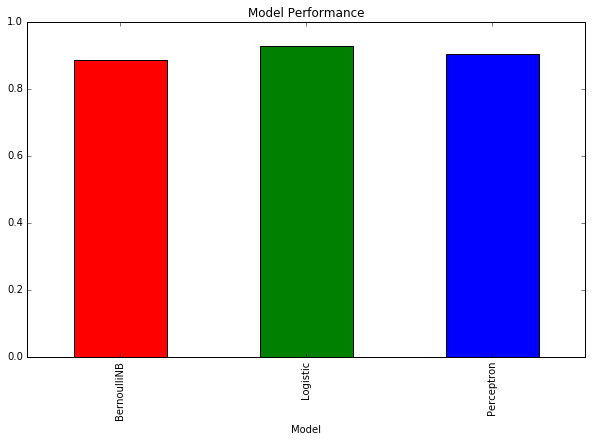

In [210]:
results_all_bi.plot(kind='bar',color=['r','g','b'],title='Model Performance',figsize=(10,6),x='Model',legend=False)

In [211]:
## comparing negative samples accuracies
negcom = pd.DataFrame()
for name,model in models.items():
    p= recall_score(Test_labels,tfprediction[name],pos_label='neg')
    negcom.loc[name,'recall'] = p

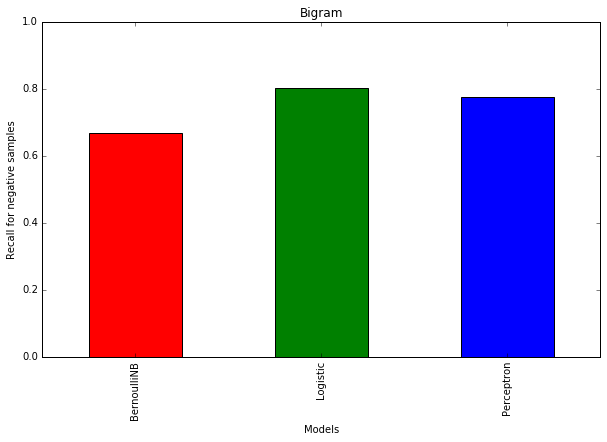

In [212]:
pl = negcom.plot(kind='bar',color=['r','g','b','y'],title='Bigram',figsize=(10,6),legend=False)
pl.set(xlabel='Models',ylabel='Recall for negative samples')
lim = plt.ylim([0,1])

### c. Using Trigrams

In [213]:
## using countvectorizer to generate count vectors for the training data.
vec_all = CountVectorizer(ngram_range=(1,3))
ctr_features_all = vec_all.fit_transform(Data_train)

In [214]:
tf_vec_all = TfidfTransformer()
tr_features_all = tf_vec_all.fit_transform(ctr_features_all)

In [215]:
cte_features_all = vec_all.transform(Data_test)
te_features_all = tf_vec_all.transform(cte_features_all)

In [216]:
results_all_tri = pd.DataFrame()

#stratified = StratifiedKFold(labels, n_folds=5,random_state=20160121, shuffle=True)
tfprediction = {}
cprediction = {}
foldnum = 0
for name,model in models.items():
        
        model.fit(tr_features_all, Train_labels)
        tfprediction[name] = model.predict(te_features_all)
        tfaccuracy = metrics.accuracy_score(tfprediction[name],Test_labels)
        
        #model.fit(ctr_features_all,Train_labels)
        #cprediction[name] = model.predict(cte_features_all)
        #caccuracy = metrics.accuracy_score(cprediction[name],Test_labels)
        
        results_all_tri.loc[foldnum,'TF-IDF Accuracy']=tfaccuracy
        #results_all_tri.loc[foldnum,'Count Accuracy']=caccuracy
        results_all_tri.loc[foldnum,'Model']=name
        foldnum = foldnum+1
print (results_all_tri)


   TF-IDF Accuracy        Model
0         0.870041  BernoulliNB
1         0.932456     Logistic
2         0.919227   Perceptron


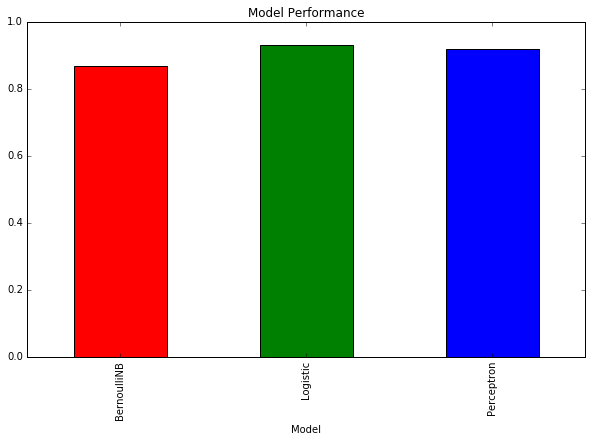

In [217]:
results_all_tri.plot(kind='bar',color=['r','g','b'],title='Model Performance',figsize=(10,6),x='Model',legend=False)

In [218]:
for name,model in models.items():
    print ("Classification report for ",name)
    print(metrics.classification_report(Test_labels, tfprediction[name]))
    print("\n")

Classification report for  BernoulliNB
             precision    recall  f1-score   support

        neg       0.83      0.51      0.63     31169
        pos       0.88      0.97      0.92    110945

avg / total       0.87      0.87      0.86    142114



Classification report for  Logistic
             precision    recall  f1-score   support

        neg       0.87      0.82      0.84     31169
        pos       0.95      0.96      0.96    110945

avg / total       0.93      0.93      0.93    142114



Classification report for  Perceptron
             precision    recall  f1-score   support

        neg       0.83      0.80      0.81     31169
        pos       0.94      0.95      0.95    110945

avg / total       0.92      0.92      0.92    142114





In [219]:
## comparing negative samples accuracies
negcom = pd.DataFrame()
for name,model in models.items():
    p= recall_score(Test_labels,tfprediction[name],pos_label='neg')
    negcom.loc[name,'recall'] = p

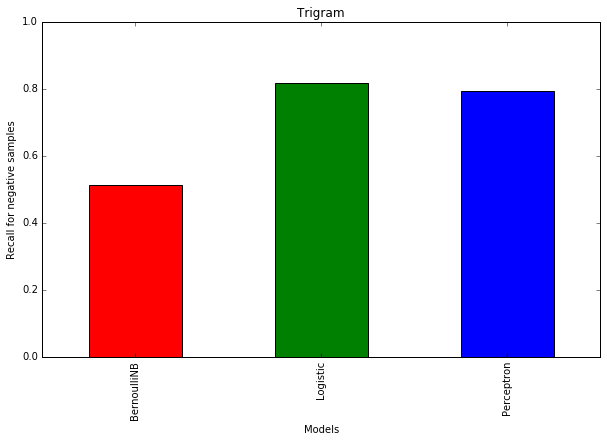

In [220]:
pl = negcom.plot(kind='bar',color=['r','g','b','y'],title='Trigram',figsize=(10,6),legend=False)
pl.set(xlabel='Models',ylabel='Recall for negative samples')
lim = plt.ylim([0,1])

In [225]:
## this code is taken from: https://www.kaggle.com/gpayen/d/snap/amazon-fine-food-reviews/building-a-prediction-model

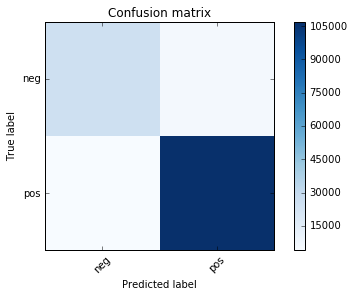

In [221]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(set(labels)))
    plt.xticks(tick_marks, ['neg','pos'], rotation=45)
    plt.yticks(tick_marks, ['neg','pos'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
cm = confusion_matrix(Test_labels, tfprediction['Logistic'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm)    

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()

In [ ]:
## Thank you